<a href="https://colab.research.google.com/github/humbertosouza/rl/blob/master/random_rl_stock_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Random RL Stock script**

It is basically the same script. However, it replaces the agent witha random action generator.

It is done in the class play_one_episode.

The subfolder names hold the name 'linear_rl_trader_random_*'


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle

from sklearn.preprocessing import StandardScaler

**Auxiliary non-core functions**

The following functions handles the csv datasource, folder creation and the scaler for the linear model preparation.

Scaler is of utmost importance to balance very different variables such as asset price, cash available and number of stocks held.

The datasource is expected to be already 'clean'

It is handled differently when running from colab or from a server (to be called from an API). Refer to 'Main Section' to know more.


In [0]:
# Auxiliary functions (non-core)
# ==============================

# The stock Reference is AAPL (Apple), MSI (Motorola), SBUX (Starbucks)
# returns a T x 3 list of stock prices
# each row is a different stock
# 0 = AAPL
# 1 = MSI
# 2 = SBUX
# You may use 'https://github.com/humbertosouza/rl/blob/master/assignment4/aapl_msi_sbux.csv'
#
# *** OR ***
# The asset reference will be the BTCUSD price
#  you may use 'https://github.com/humbertosouza/rl/blob/master/assignment4/BTCUSDT-4h-data-pure.csv'

def get_data(url):
  df = pd.read_csv(url)
  return df.values

# return scikit-learn scaler object to scale the states
# Note: you could also populate the replay buffer here
def get_scaler(env):

  states = []
  for _ in range(env.n_step):
    action = np.random.choice(env.action_space)
    state, reward, done, info = env.step(action)
    states.append(state)
    if done:
      break

  scaler = StandardScaler()
  scaler.fit(states)
  return scaler

# Creates the foder 'directory' if it does not exist
def maybe_make_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)

# Creates the header of a text file for the rewards
# Useful for analysis of the hyperparameters
def write_txt_header(reward_txt_file, num_episodes,batch_size,initial_investment):
  f=open(reward_txt_file,"a+")
  f.write("-----------------------------------------------\r\n")
  f.write("----------- Starting new cycle ----------------\r\n")
  f.write("-----------------------------------------------\r\n")
  txt_now = f'{datetime.now()}'
  f.write(txt_now)
  f.write("\r\n")
  f.write(f'Paramenters: num_episodes:{num_episodes}; batch_size:{batch_size}; initial_investiment:{initial_investment}')
  f.write("\r\n")
  f.close()


# End of the Auxiliary functions (non-core)
# =========================================


**SGD Linear Model Class**

The Linear Model implements the functions 

- Predict
- sgd

The sgd method implements momentum (W,b) to make the model to cope with the latest trend agains the older ones. It relies on a one-step descent.

**SGL Linear Model auxiliary functions**

In order to make it faster 

It also contains the auxiliary functions
- load_weights (from a numpy file)
- save_weights (to a numpy file)



In [0]:
# Implements manually a Linear Model class using Stochastic Gradient Descent
class LinearModel:
  """ A linear regression model """
  def __init__(self, input_dim, n_action):
    self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
    self.b = np.zeros(n_action)

    # momentum terms
    self.vW = 0
    self.vb = 0

    self.losses = []

  def predict(self, X):
    # make sure X is N x D
    assert(len(X.shape) == 2)
    return X.dot(self.W) + self.b

  def sgd(self, X, Y, learning_rate=0.01, momentum=0.9):
    # make sure X is N x D
    assert(len(X.shape) == 2)

    # the loss values are 2-D
    # normally we would divide by N only
    # but now we divide by N x K
    num_values = np.prod(Y.shape)

    # do one step of gradient descent
    # we multiply by 2 to get the exact gradient
    # (not adjusting the learning rate)
    # i.e. d/dx (x^2) --> 2x
    Yhat = self.predict(X)
    gW = 2 * X.T.dot(Yhat - Y) / num_values
    gb = 2 * (Yhat - Y).sum(axis=0) / num_values

    # update momentum terms
    self.vW = momentum * self.vW - learning_rate * gW
    self.vb = momentum * self.vb - learning_rate * gb

    # update params
    self.W += self.vW
    self.b += self.vb

    mse = np.mean((Yhat - Y)**2)
    self.losses.append(mse)

  # Load weights from Numpy file
  def load_weights(self, filepath):
    npz = np.load(filepath)
    self.W = npz['W']
    self.b = npz['b']
    
  # Save weights to Numpy file
  def save_weights(self, filepath):
    np.savez(filepath, W=self.W, b=self.b)


**Multi stock environment class** (3 classes)

This class reads the EOD stock prices and makes a decision about what to do with each of them:
0. Sell
1. Buy
2. Hold

The environment itself is a vector which contains 7 variables.

[assetOwned1,assetOwned2,assetOwned3,priceAsset1,priceAsset2,priceAsset3,cashOwned]

It also implements reset which is important for reinitialize the environment and start the next iteration.

The environment also implements the step function. It performs the needed updates to provide the agent with the results of all variables in the environment. It also conforms with th OpenAI gym API.

The method trade performs the buys and sells accoding to the actions to be taken. It is used in the main method  to populate the env variable that feeds the agent. If under test, it is reloaded with the test data.



In [0]:
# Original class that handles 3-stocks at once
class MultiStockEnv:
  """
  A 3-stock trading environment.
  State: vector of size 7 (n_stock * 2 + 1)
    - # shares of stock 1 owned
    - # shares of stock 2 owned
    - # shares of stock 3 owned
    - price of stock 1 (using daily close price)
    - price of stock 2
    - price of stock 3
    - cash owned (can be used to purchase more stocks)
  Action: categorical variable with 27 (3^3) possibilities
    - for each stock, you can:
    - 0 = sell
    - 1 = hold
    - 2 = buy
  """
  def __init__(self, data, initial_investment=20000):
    # data
    self.stock_price_history = data
    self.n_step, self.n_stock = self.stock_price_history.shape

    # instance attributes
    self.initial_investment = initial_investment
    self.cur_step = None
    self.stock_owned = None
    self.stock_price = None
    self.cash_in_hand = None

    self.action_space = np.arange(3**self.n_stock)

    # action permutations
    # returns a nested list with elements like:
    # [0,0,0]
    # [0,0,1]
    # [0,0,2]
    # [0,1,0]
    # [0,1,1]
    # etc.
    # 0 = sell
    # 1 = hold
    # 2 = buy
    self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

    # calculate size of state
    self.state_dim = self.n_stock * 2 + 1

    self.reset()


  def reset(self):
    self.cur_step = 0
    self.stock_owned = np.zeros(self.n_stock)
    self.stock_price = self.stock_price_history[self.cur_step]
    self.cash_in_hand = self.initial_investment
    return self._get_obs()


  def step(self, action):
    assert action in self.action_space

    # get current value before performing the action
    prev_val = self._get_val()

    # update price, i.e. go to the next day
    self.cur_step += 1
    self.stock_price = self.stock_price_history[self.cur_step]

    # perform the trade
    self._trade(action)

    # get the new value after taking the action
    cur_val = self._get_val()

    # reward is the increase in porfolio value
    reward = cur_val - prev_val

    # done if we have run out of data
    done = self.cur_step == self.n_step - 1

    # store the current value of the portfolio here
    info = {'cur_val': cur_val}

    # conform to the Gym API
    return self._get_obs(), reward, done, info


  def _get_obs(self):
    obs = np.empty(self.state_dim)
    obs[:self.n_stock] = self.stock_owned
    obs[self.n_stock:2*self.n_stock] = self.stock_price
    obs[-1] = self.cash_in_hand
    return obs
    


  def _get_val(self):
    return self.stock_owned.dot(self.stock_price) + self.cash_in_hand


  def _trade(self, action):
    # index the action we want to perform
    # 0 = sell
    # 1 = hold
    # 2 = buy
    # e.g. [2,1,0] means:
    # buy first stock
    # hold second stock
    # sell third stock
    action_vec = self.action_list[action]

    # determine which stocks to buy or sell
    sell_index = [] # stores index of stocks we want to sell
    buy_index = [] # stores index of stocks we want to buy
    for i, a in enumerate(action_vec):
      if a == 0:
        sell_index.append(i)
      elif a == 2:
        buy_index.append(i)

    # sell any stocks we want to sell
    # then buy any stocks we want to buy
    if sell_index:
      # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
      for i in sell_index:
        self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
        self.stock_owned[i] = 0
    if buy_index:
      # NOTE: when buying, we will loop through each stock we want to buy,
      #       and buy one share at a time until we run out of cash
      can_buy = True
      while can_buy:
        for i in buy_index:
          if self.cash_in_hand > self.stock_price[i]:
            self.stock_owned[i] += 1 # buy one share
            self.cash_in_hand -= self.stock_price[i]
          else:
            can_buy = False


**Agent Class**

This class implements the agent that relies on the linear model to define the error amongst the actions taken in a given state. Q(s,;)
It is a e-greedy approach with a decaying factor and minimum defined in its __init__ function.
The RL policy will vary according to the iterations ineach batch.


In [0]:
class DQNAgent(object):
  def __init__(self, state_size, action_size, gamma=0.95, epsilon=1.0):
    self.state_size = state_size
    self.action_size = action_size
    self.gamma = gamma  # discount rate
    self.epsilon = epsilon  # exploration rate
    self.epsilon_min = 0.05
    self.epsilon_decay = 0.995
    self.model = LinearModel(state_size, action_size)

  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])  # returns action


  def train(self, state, action, reward, next_state, done):
    if done:
      target = reward
    else:
      target = reward + self.gamma * np.amax(self.model.predict(next_state), axis=1)

    target_full = self.model.predict(state)
    target_full[0, action] = target

    # Run one training step
    self.model.sgd(state, target_full)

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay


  def load(self, name):
    self.model.load_weights(name)


  def save(self, name):
    self.model.save_weights(name)





**Play one episode class**

The class where a full state is handled.

It gets the current state of the environment, rescales.

Then it will play the episode until it is done.
In the loop,the agent takes an action based on the current state.

Then the action is applied to the environment via env.step. It returns the tuple next_state,reward,done and info.

Inside the loop it is also verified if we are in train mode. If so, it calls the agent.train.

Finally, the last action of the loop is apply the state to the recently acquired next_state variable.

The function returns the curent portfolio value.

In [0]:
def play_one_episode(agent, env, is_train):
  # note: after transforming states are already 1xD
  state = env.reset()
  state = scaler.transform([state])
  done = False

  while not done:
    #action = agent.act(state)
    action = np.random.choice(env.action_space) # Use random for comparison
    next_state, reward, done, info = env.step(action)
    next_state = scaler.transform([next_state])
    if is_train == 'train':
      agent.train(state, action, reward, next_state, done)
    state = next_state

  return info['cur_val']

**Main section**

The next section is the "main" section when converting it to run under a server, as a .py file.

> The 'Main'  does the following:

1. Defines in which folder the models will be saved
2. Defines the folder where the rewards will be saved  
3. Check if it is train or test
4.   Load the dataset
5.   Define # of episodes, batch size and initial investment
5. split the data in train and test (dividing the dataset in 2)
6.   Loads the environment, agent and run train or test
8. Instantiate the objects using the parameters loaded into the variables
7.   Save the train (pandas) file for future usage
8.   Plot the chart***

The train /test cycle is expected to happen after every new cycle. In this case, new EOD - end of day trigger)








Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
train-0.95-0.95 - average reward: 29164.71, min: 12772.88, max: 59095.46
2019-12-07 01:51:53.537447


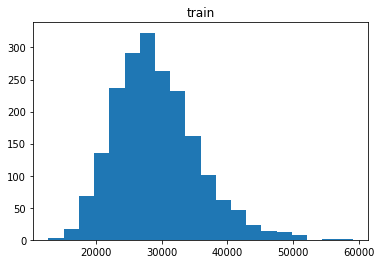

test-0.95-0.95 - average reward: 25474.98, min: 12004.53, max: 49883.70
2019-12-07 01:55:34.668414


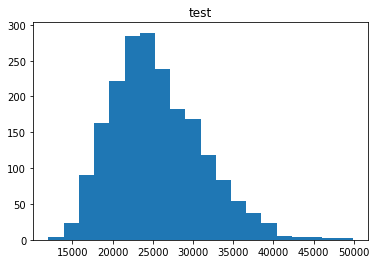

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [8]:
# Adapted to run via Colab
# ------------------------
from google.colab import drive
drive.mount('/content/drive')

# For tests, adjusts and evaluation require the files:
#
# BTCUSDT-4h-data-pure.csv
#  *or*
# aapl_msi_sbux.csv


# Set hyperparameters
# (gamma, epslon, mode)
# The parameters vary between 1 and 0
# Mode can be train or test
exploreHyper = [
    (0.95,0.95,'train'),(0.95,0.95,'test'),
    (0.95,0.6,'train'),(0.95,0.6,'test'),
  #  (0.75,0.95,'train'),(0.75,0.95,'test'),
  #  (0.75,0.6,'train'),(0.75,0.6,'test'),
  #  (0.55,0.95,'train'),(0.55,0.95,'test'),
  #  (0.55,0.6,'train'),(0.55,0.6,'test'),
  #  (0.45,0.95,'train'),(0.45,0.95,'test'),
  #  (0.45,0.6,'train'),(0.45,0.6,'test'),
]  
  
# config
num_episodes = 2000
batch_size = 16
initial_investment = 20000
# Select source file
#file = f'/content/drive/My Drive/Colab Notebooks/rl/final/BTCUSDT-4h-data-pure.csv'
file = f'/content/drive/My Drive/Colab Notebooks/rl/final/aapl_msi_sbux.csv' 

# Report text file containing the rewards from different parameters
reward_txt_file = f'/content/drive/My Drive/Colab Notebooks/rl/final/rewards_report.txt'

write_txt_header(reward_txt_file,num_episodes,batch_size,initial_investment)

for gamma,epsilon, mode in exploreHyper:  
  colabEnv = mode
  models_folder = f'/content/drive/My Drive/Colab Notebooks/rl/final/linear_rl_trader_random_models_{gamma}_{epsilon}'
  rewards_folder = f'/content/drive/My Drive/Colab Notebooks/rl/final/linear_rl_trader_random_rewards_{gamma}_{epsilon}'

  maybe_make_dir(models_folder)
  maybe_make_dir(rewards_folder)
  
  # Read the CSV file and por to a numpy dataframe
  data = get_data(file)

  n_timesteps, n_stocks = data.shape

  # use 50% of the data for train and test
  n_train = n_timesteps // 2

  train_data = data[:n_train]
  test_data = data[n_train:]

  env = MultiStockEnv(train_data, initial_investment)
  state_size = env.state_dim
  action_size = len(env.action_space)
  agent = DQNAgent(state_size, action_size, gamma, epsilon)
  scaler = get_scaler(env)

  # store the final value of the portfolio (end of episode)
  portfolio_value = []

  if (colabEnv =='test'):
    # then load the previous scaler
    #with open(f'{models_folder}/scaler.pkl', 'rb') as f:
    #  scaler = pickle.load(f)

    # remake the env with test data
    env = MultiStockEnv(test_data, initial_investment)

    # make sure epsilon is not 1!
    # no need to run multiple episodes if epsilon = 0, it's deterministic
    #agent.epsilon = 0.01 

    # load trained weights colab pd.read_csv
    #agent.load(f'{models_folder}/linear.npz')

  # play the game num_episodes times
  for e in range(num_episodes):
    t0 = datetime.now()
    val = play_one_episode(agent, env, colabEnv)
    dt = datetime.now() - t0
    #print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
    portfolio_value.append(val) # append episode end portfolio value

  # save the weights when we are done
  #if (colabEnv =='train'):
    # save the DQN
    #agent.save(f'{models_folder}/linear.npz')

    # save the scaler
    #with open(f'{models_folder}/scaler.pkl', 'wb') as f:
    #  pickle.dump(scaler, f)

    # plot losses
    #plt.plot(agent.model.losses)
    #plt.savefig(f'{rewards_folder}/{mode}-losses.png')
    #plt.show()
    #plt.clf()


  # save portfolio value for each episode
  np.save(f'{rewards_folder}/{mode}.npy', portfolio_value)


  # =============================================================
  # Print reward charts
  # =============================================================

  url = f'{rewards_folder}/{mode}.npy'
  a = np.load(url)

  text = f"{mode}-{gamma}-{epsilon} - average reward: {a.mean():.2f}, min: {a.min():.2f}, max: {a.max():.2f}"
  print(text)

  f=open(reward_txt_file,"a+")
  f.write(text)
  f.write("\r\n")
  txt_now = f'{datetime.now()}'
  f.write(txt_now)
  print(txt_now)    
  f.write("\r\n")  
  f.close()

  plt.hist(a, bins=20)
  plt.title(mode)
  # Prepare to save the figure
  fig1 = plt.gcf()
  plt.show()

  fig1.savefig(f'{rewards_folder}/{mode}-{a.mean()}.png')
  plt.clf()